Programmed on: 2025/01/25

The purpose of this script is to establish a CNN model to map the rough surface with the resulting strain concentration under axial loading.

This CNN model is referred to the idea in GitHub [Deep DIC](https://github.com/RuYangNU/Deep-Dic-deep-learning-based-digital-image-correlation/blob/main/DisplacementNet_train.ipynb)

2025/02/06
The input size will be adjusted to 53x53. Residual block will be used.

2025/03/14
The script has been updated to run locally.

# Libraries

Import the libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import numpy as np
import math
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import BasicBlock, Bottleneck, ResNet
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
import openpyxl
from openpyxl import load_workbook

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import re

In [2]:
# import torch
if torch.cuda.is_available():
    print(f"CUDA is available, GPU device {torch.cuda.get_device_name(0)}")
else:
    print(f"CUDA is not available!")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Is CUDA available: {torch.cuda.is_available()}")

CUDA is available, GPU device NVIDIA GeForce RTX 3050 Laptop GPU
PyTorch version: 1.12.1+cu116
CUDA version: 11.6
cuDNN version: 8302
Is CUDA available: True


In [3]:
input_rough_surface_folder = 'C:\\Abaqus_Works\\roughness_simulation\\input_rough_surfaces'
structured_grid_xls_folder = 'C:\\Abaqus_Works\\roughness_simulation\\output_structured_grid'
model_results_folder = 'C:\\Abaqus_Works\\roughness_simulation'

load_cases = ['TENSILE_X','TENSILE_Y','SHEAR']
idx_load_case = 2
print(f"Current loading case for TRAINing is {load_cases[idx_load_case]}")

layers = 4
sub_layers = 2
in_channels = 1
print(f"Please confirm the number of layers of network is {layers} and sub_layers is {sub_layers} and in_channels is {in_channels}")

use_bn = True
if not use_bn:
    print(f"Batch normalization will *NOT* be used!")
else:
    print(f"Batch normalization will *YES* be used!")

use_skip = True
if use_skip:
    print(f"Skip connection between encoder and decoder will *YES* be used!")
else:
    print(f"Skip connection between encoder and decoder will *NOT* be used!")


Current loading case for TRAINing is SHEAR
Please confirm the number of layers of network is 4 and sub_layers is 2 and in_channels is 1
Batch normalization will *YES* be used!
Skip connection between encoder and decoder will *YES* be used!


# Dataset class

create the dataset class

In [4]:
class RoughnessStressFactorDataset(Dataset):
    def __init__(self, roughness_paths, stress_factor_paths, idx_load_case):
        self.roughness_paths = roughness_paths   # roughness matrix
        self.stress_factor_paths = stress_factor_paths # strain intensity matrix
        self.idx_load_case = idx_load_case

    def __len__(self):
        return len(self.roughness_paths)

    def __getitem__(self, idx):
        # the roughness data is saved in 'csv' files
        # roughness_matrix = np.loadtxt(self.roughness_paths[idx], delimiter=',')
        # roughness_matrix = roughness_matrix * 1000.0  # in the unit of micrometers
        #--------------------------------------------------------------------------------------
        # roughness profiles, height, dR/dx, dR/dy
        sheets_rough = []
        
        for i in range(3):
            sheet = pd.read_excel(self.roughness_paths[idx], sheet_name=i, header=None)
            if i == 0:
                sheet = sheet* 1000.0
            sheets_rough.append(sheet.values)

        # stack the sheets into a 3D NumPy array
        roughness_matrix = np.stack(sheets_rough, axis=-1)
        
        # Transpose the tensor to shape (3, 160, 160)
        roughness_matrix = np.transpose(roughness_matrix, (2, 0, 1))

        #--------------------------------------------------------------------------------------
        # stress concentration factors of *six* stress components under three loading situations
        sheets_stress = []
        
        for i in range(6):
            sheet = pd.read_excel(self.stress_factor_paths[idx], sheet_name=6*self.idx_load_case+i, header=None)
            sheets_stress.append(sheet.values)

        # stack the sheets into a 3D NumPy array
        stress_factor_tensor = np.stack(sheets_stress, axis=-1)
        
        # Transpose the tensor to shape (6, 160, 160)
        stress_factor_tensor = np.transpose(stress_factor_tensor, (2, 0, 1))

        # extract the id of the xlsx file
        # Use a regular expression to extract the integer after 'ID' and before '.'
        match = re.search(r'ID(\d+)\.', self.roughness_paths[idx])
        if match:
            id_roughness = int(match.group(1))  # Convert the matched string to an integer
        else:
            print("No ID found in the string.")
        return roughness_matrix, stress_factor_tensor, id_roughness


# Dataset instantiation

prepare the dataset and dataloader

In [5]:
# generate data array from 0 to 10000 (not including 10000)
id_array = np.arange(1000)

# shuffle the ids
np.random.shuffle(id_array)

# seperate the ids into two parts for training and testing
train_size = int(0.8*len(id_array))
val_size   = int(0.1*len(id_array))
test_size  = len(id_array) - train_size - val_size

train_ids  = id_array[:train_size]
val_ids    = id_array[train_size:(train_size + val_size)]
test_ids   = id_array[(train_size + val_size):]

# Length of the square model
full_length_um = 636
# half of the crop grids on the border
half_crop_grids = 0
# times in meshing elements
sub_times = 1

# form the list with the paths to these csv files
# training dataset
train_roughness_paths     = []
train_stress_factor_paths = []
for id in train_ids:
    input_path  = f"input_surface_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"
    output_path = f"output_norm_stress_struct_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"

    # os.path.join(input_rough_surface_folder, input_path)
    train_roughness_paths.append(    os.path.join(input_rough_surface_folder, input_path))
    train_stress_factor_paths.append(os.path.join(structured_grid_xls_folder , output_path))

# validation dataset
val_roughness_paths     = []
val_stress_factor_paths = []
for id in val_ids:
    input_path  = f"input_surface_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"
    output_path = f"output_norm_stress_struct_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"

    val_roughness_paths.append(    os.path.join(input_rough_surface_folder, input_path))
    val_stress_factor_paths.append(os.path.join(structured_grid_xls_folder, output_path))


# testing dataset
test_roughness_paths     = []
test_stress_factor_paths = []
for id in test_ids:
    input_path  = f"input_surface_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"
    output_path = f"output_norm_stress_struct_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"

    test_roughness_paths.append(   os.path.join(input_rough_surface_folder, input_path))
    test_stress_factor_paths.append(os.path.join(structured_grid_xls_folder, output_path))

train_dataset = RoughnessStressFactorDataset(train_roughness_paths, train_stress_factor_paths, idx_load_case)
val_dataset   = RoughnessStressFactorDataset(  val_roughness_paths,   val_stress_factor_paths, idx_load_case)
test_dataset  = RoughnessStressFactorDataset( test_roughness_paths,  test_stress_factor_paths, idx_load_case)

batch_size = 10
print(f"training batch size = {batch_size}")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=1,          shuffle=False)


training batch size = 10


# CNN class

* Referring to [U-Net1](https://zhuanlan.zhihu.com/p/313283141), double convolution layers are created below
* Single **Conv2d+BN+PReLU**, double 2x(**Conv2d+BN+PReLU**) and Single **ConvTranspose2d+BN+PReLU** are constructed below
* More explaination about transpose convolution can be found [Transpose Convolution-1](https://zhuanlan.zhihu.com/p/59905022)
* The way to calculate output size of the Conv2d, pooling and ConvTranspose2d can be found in [CNN stride kernel padding](https://zhuanlan.zhihu.com/p/115752890)


* Referring to [U-Net](https://zhuanlan.zhihu.com/p/313283141), encoder and decoder are used
* Probably, residual block will be used if the net cannot be trained
* according [ResNet](https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html) and [ResNet-Zhihu](https://zhuanlan.zhihu.com/p/31852747), residual block can be inserted in the deep layers perhaps?
* If it is necessry, the parameters shall be initialized
* The initial input size is 32 x 32 ㊙
* Now the new CNN was generated by copilot

References:
1.   [U-Net1](https://zhuanlan.zhihu.com/p/313283141)
2.   [U-Net2](https://zhuanlan.zhihu.com/p/43927696)
3.   [U-Net3](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)


In [17]:
#   Single Conv2d+BN+ReLU
#   Wout=(Win-K+2P)/S+1
#   default setting (K = 3, S = 1 and P = 1) will maintain the size of the output images
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):  # default setting of kernel_size, stride and padding will keep the size same
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
#         # self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         # out = self.relu(self.bn(self.conv(x)))
#         out = self.relu(self.conv(x))
#         return out

#   Single ConvTranspose2d+BN+ReLU
#   Wout=(Win-1)*S+K-2P
#   default setting (K = 2, S = 2, P = 0) will also maintain the size of the output images
class TransposeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0, use_bn=False):  # default setting of kernel_size, stride and padding will double the size
        """
        Parameters:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - stride: Stride of the convolution
        - padding: Padding added to both sides of the input
        - use_bn: Whether to include BatchNorm2d
        """
        super(TransposeConvBlock, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=not use_bn)
        ]

        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
        # ReLU
        # layers.append(nn.ReLU(inplace=True))
        # PReLU
        layers.append(nn.PReLU(num_parameters=out_channels))

        self.transpose_conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.transpose_conv_block(x)

#   Doulbe Conv2d+BN+ReLU
#   Wout=(Win-K+2P)/S+1
#   default setting (K = 3, S = 1 and P = 1) will maintain the size of the output images
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, sub_layers=2, use_bn=False):
        """
        Parameters:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - stride: Stride of the convolution
        - padding: Padding added to both sides of the input
        - sub_layers: Subsequent layers
        - use_bn: Whether to include BatchNorm2d
        """
        super(ConvBlock, self).__init__()

        first_layer = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=not use_bn)
        ]
        if use_bn:
            first_layer.append(nn.BatchNorm2d(out_channels))
        # ReLU
        # first_layer.append(nn.ReLU(inplace=True))
        # PReLU
        first_layer.append(nn.PReLU(num_parameters=out_channels))

        subseq_layers = []    
        for _ in range(sub_layers-1):
            subseq_layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=not use_bn))
            if use_bn:
                subseq_layers.append(nn.BatchNorm2d(out_channels))
            # ReLU
            # subseq_layers.append(nn.ReLU(inplace=True))
            # PReLU
            subseq_layers.append(nn.PReLU(num_parameters=out_channels))

        self.conv_block1 = nn.Sequential(*first_layer)
        self.conv_block2 = nn.Sequential(*subseq_layers)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

![U-Net figure](unet_roughness.jpg)

In [18]:

class RoughnessStressFactorNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=6, base_channels=64, layers=3, sub_layers=2, use_bn=False, use_skip=True):
        """
        Parameters:
        - in_channels: Number of input channels (default: 1)
        - out_channels: Number of output channels (default: 6)
        - base_channels: Number of channels in the first layer (default: 64)
        - layers: Number of encoder/decoder layers (default: 3)
        - sub_layers: Number of sub-layers in each main layer (default: 2)
        - use_bn: Switch of batch normalization (default is False)
        - use_skip: Switch of skip connection between encoder and decoder (default is True)
        """
        super(RoughnessStressFactorNet, self).__init__()
        
        self.layers = layers
        self.use_skip   = use_skip
        # Encoder layers
        # (save the conv and pool from top layer to bottom layer)
        self.encoder_convs = nn.ModuleList()
        self.encoder_pools = nn.ModuleList()
        for i in range(layers):
            in_ch = in_channels if i == 0 else base_channels * (2 ** (i - 1))
            out_ch = base_channels * (2 ** i)
            self.encoder_convs.append(ConvBlock(in_ch, out_ch, sub_layers=sub_layers, use_bn=use_bn))
            if i < layers - 1:  # No pooling after the last encoder layer
                self.encoder_pools.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Decoder layers 
        # (save the tconv and conv from bottom layer to top layer)
        self.decoder_tconvs = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        for i in range(layers - 1, 0, -1):
            in_ch = base_channels * (2 ** i)
            out_ch = base_channels * (2 ** (i - 1))
            self.decoder_tconvs.append(TransposeConvBlock(in_ch, out_ch, use_bn=use_bn))

            # if skip connection is used or not
            if use_skip:
                self.decoder_convs.append(ConvBlock(in_ch,  out_ch, sub_layers=sub_layers, use_bn=use_bn))
            else:
                self.decoder_convs.append(ConvBlock(out_ch, out_ch, sub_layers=sub_layers, use_bn=use_bn))

        # Final output layer
        self.decoder_output_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Encoder forward pass
        encoder_outputs = []
        for i in range(self.layers):
            x = self.encoder_convs[i](x)
            encoder_outputs.append(x)  # Save for skip connections
            if i < self.layers - 1:  # Apply pooling except for the last layer
                x = self.encoder_pools[i](x)

        # Decoder forward pass
        for i in range(self.layers - 1):
            skip_connection = encoder_outputs[-(i + 2)]  # Get corresponding encoder output
            x = self.decoder_tconvs[i](x)
            # skip connection is use or not
            if self.use_skip:
                x = torch.cat([x, skip_connection], dim=1)  # Skip connection
            
            x = self.decoder_convs[i](x)

        # Final output layer
        out = self.decoder_output_conv(x)
        return out

# Setting

* Instantiate the roughness strain intensity factor net
* setting learning rate, optimizer, criterion and device
* Hyperparameters like learning rate, batch size, network architecture shall be searched

In [8]:
# Instantiate the model
# model = RoughnessStressFactorNet(in_channels=1, out_channels=6, layers=layers, sub_layers=sub_layers, 
#                                  use_bn=use_bn, use_skip=use_skip)

model = RoughnessStressFactorNet(in_channels=in_channels, out_channels=6, layers=layers, sub_layers=sub_layers, 
                                 use_bn=use_bn, use_skip=use_skip)

# Set learning rate
learning_rate = 0.001

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # , momentum=0.9?
# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
# Define loss criterion
criterion = nn.MSELoss()

# Check if GPU is available and move model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using {device} for training.")


Using cuda for training.


# Training

In [9]:
num_epochs = 40  # Example number of epochs

loss_train_val = np.zeros((num_epochs, 2))

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    # print(f"Current Epoch [{epoch+1}]")
    # Iterate over data batches
    for i, (inputs, targets, _) in enumerate(train_dataloader):

        inputs = inputs[:, 0:in_channels, :, :].float().to(device)
        targets = targets.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, targets)  # Define your loss function here
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # Print statistics
        # if i % 10 == 9:    # Print every 10 mini-batches
        #     print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {train_loss / 9:.4f}")
        #     running_loss = 0.0
        # print(f"currernt batch is {i}")
        # print(f"****************************************************************************************************")
        # print(model.encoder_layer3_conv.bn.running_mean[0])
        # print(model.encoder_layer3_conv.bn.running_var[0])
        print(f"Current Epoch [{epoch+1}] and batch [{i+1}]")
    # Average training loss
    train_loss /= len(train_dataloader)

    # Validation step
    model.eval()
    # print(model.encoder_layer3_conv.bn.running_mean)
    # print(model.encoder_layer3_conv.bn.running_var)

    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, _ in val_dataloader:
            inputs = inputs[:, 0:in_channels, :, :].float().to(device)
            targets = targets.float().to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_dataloader)

    # Update the learning rate based on validation loss
    scheduler.step(val_loss)
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    print(f"[{current_time}] Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # save the train and val loss
    loss_train_val[epoch, :] = train_loss, val_loss

# Optionally, save the trained model
model_name = f"roughness_stress_factor_net_{load_cases[idx_load_case]}_LAY{int(layers)}_SubL{int(sub_layers)}_In{in_channels}_PReLU.pth"
torch.save(model.state_dict(), model_name)

# Save the train and val loss to an excel file
name_train_val_res = f"net_{load_cases[idx_load_case]}_L{int(layers)}_SubL{int(sub_layers)}_In{in_channels}_PReLU.xlsx"
path_train_val_res = os.path.join(model_results_folder, name_train_val_res)

with pd.ExcelWriter(path_train_val_res, engine='openpyxl') as writer:
    sheet_name = f"{load_cases[idx_load_case]}-L{int(layers)}-SubL{int(sub_layers)}-In{in_channels}-PReLU"
    df = pd.DataFrame(loss_train_val[:, :])
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)


Current Epoch [1] and batch [1]
Current Epoch [1] and batch [2]
Current Epoch [1] and batch [3]
Current Epoch [1] and batch [4]
Current Epoch [1] and batch [5]
Current Epoch [1] and batch [6]
Current Epoch [1] and batch [7]
Current Epoch [1] and batch [8]
Current Epoch [1] and batch [9]
Current Epoch [1] and batch [10]
Current Epoch [1] and batch [11]
Current Epoch [1] and batch [12]
Current Epoch [1] and batch [13]
Current Epoch [1] and batch [14]
Current Epoch [1] and batch [15]
Current Epoch [1] and batch [16]
Current Epoch [1] and batch [17]
Current Epoch [1] and batch [18]
Current Epoch [1] and batch [19]
Current Epoch [1] and batch [20]
Current Epoch [1] and batch [21]
Current Epoch [1] and batch [22]
Current Epoch [1] and batch [23]
Current Epoch [1] and batch [24]
Current Epoch [1] and batch [25]
Current Epoch [1] and batch [26]
Current Epoch [1] and batch [27]
Current Epoch [1] and batch [28]
Current Epoch [1] and batch [29]
Current Epoch [1] and batch [30]
Current Epoch [1] a

# Testing

In [8]:
def calculate_tick_increment(vmin, vmax, num_ticks=10):
    """
    Dynamically calculate the increment for colorbar ticks.
    Parameters:
    - vmin: Minimum value of the range.
    - vmax: Maximum value of the range.
    - num_ticks: Desired number of ticks (default: 5).
    Returns:
    - increment: The calculated increment for the ticks.
    """
    range_values = vmax - vmin
    raw_increment = range_values / (num_ticks - 1)  # Divide range into (num_ticks - 1) intervals

    if raw_increment == 0:
        raise ValueError("The increment value must not be zero.")

    # Get the absolute value to handle negative numbers
    abs_inc = abs(raw_increment)
    
    # Calculate the index (power of 10)
    index = math.floor(math.log10(abs_inc))

    # Scale the value to make the first digit an integer
    scaled_value = abs_inc / (10 ** index)
    
    # Extract the first digit
    first_digit = int(math.ceil(scaled_value))

    inc_reg = first_digit * 10**index
    
    low_lim_reg = np.ceil(vmin/inc_reg)*inc_reg
    upp_lim_reg = (np.floor(vmax/inc_reg)+1)*inc_reg

    bar_ticks = np.arange(low_lim_reg, upp_lim_reg, inc_reg)

    return bar_ticks

# Example function to add labels to subplots
def add_subplot_label(ax, label):
    """
    Add a label to the top-left corner of a subplot.
    
    Parameters:
    - ax: The axes object of the subplot.
    - label: The label text to add (e.g., '(a)', '(b1)', etc.).
    """
    ax.text(
        -0.06, 1.08,  # Position: near the top-left corner
        label,       # The label text
        transform=ax.transAxes,  # Use axes coordinates (0, 0 is bottom-left, 1, 1 is top-right)
        fontsize=12,  # Font size
        fontweight='bold',  # Bold text
        va='top',  # Vertical alignment
        ha='left'  # Horizontal alignment
    )


# this piece of code is from 'unet_roughness.ipynb'
def plot_norm_field_cylind(fig, axes, axs_row, axs_col, title, label, corner_label, field, crop_pix_col, org_width_mm, org_height_mm, b_cbar_axes):
    
    if crop_pix_col == 0:
        field_crop = field.T
    else:
        field_crop = field[crop_pix_col:-crop_pix_col,:].T

    # Calculate the range of the field
    vmin = np.nanmin(field_crop)
    vmax = np.nanmax(field_crop)

    # Dynamically calculate the increment for the colorbar ticks
    bar_ticks = calculate_tick_increment(vmin, vmax, num_ticks=10)

    # Create a colormap with gray for NaN values
    cmap = plt.get_cmap('jet')
    # cmap.set_bad(color='gray')
    
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True) # the range of the colorbar
    
    interval_struct_grids = 0.004
    lim_low_x = int(crop_pix_col*interval_struct_grids*1000)
    lim_upp_x = int((org_width_mm - crop_pix_col*interval_struct_grids)*1000)
    
    lim_low_y = 0
    lim_upp_y = int(org_height_mm*1000)
    area = [lim_low_x, lim_upp_x, lim_low_y, lim_upp_y]

    im_handle=axes[axs_row, axs_col].imshow(field_crop[:, :], cmap=cmap, norm=norm, interpolation="nearest", extent=area)

    font_size = 12
    # Create the colorbar and ticks of axes
    if b_cbar_axes:
        # Create a divider for the existing axes instance
        divider = make_axes_locatable(axes[axs_row, axs_col])

        # Append axes to the right of ax, with 5% width of ax
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # create colorbar
        cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=bar_ticks)
        # cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axes[axs_row, axs_col], ticks=bar_ticks)
        # cbar = fig.colorbar(im_handle, ScalarMappable(norm=norm, cmap=cmap), ax=axes[axs_row, axs_col], ticks=boundaries)
        cbar.ax.tick_params(labelsize=font_size)  # Set font size for colorbar tick labels
        cbar.set_label(label)

    # create ticks
    inc_tick = 400
    # setting ticks along X-axis
    num_x_ticks = np.floor(org_width_mm*1000/inc_tick) + 1
    max_x_ticks = (num_x_ticks - 1)*inc_tick
    x_ticks = np.linspace(0, max_x_ticks, int(num_x_ticks))
    
    # setting ticks along Y-axis
    # inc_radian = 2*np.pi/8
    # num_y_ticks = np.floor(2*np.pi/inc_radian) + 1
    # max_y_ticks = 2*np.pi
    # y_ticks = np.linspace(0, max_y_ticks, int(num_y_ticks))
    inc_tick = 600
    num_y_ticks = np.floor(org_height_mm*1000/inc_tick) + 1
    max_y_ticks = (num_y_ticks - 1)*inc_tick
    y_ticks = np.linspace(0, max_y_ticks, int(num_y_ticks))
    
    axes[axs_row, axs_col].set_xticks(x_ticks)
    axes[axs_row, axs_col].set_yticks(y_ticks)
    axes[axs_row, axs_col].set_xticklabels([f'{int(i):d}' for i in x_ticks])
    # axes[axs_row, axs_col].set_yticklabels([f'{i/2400*2*np.pi}' for i in y_ticks])
    axes[axs_row, axs_col].set_yticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
    axes[axs_row, axs_col].tick_params(axis='both', which='major', labelsize=font_size)  # Set font size for tick labels
    axes[axs_row, axs_col].set_xlabel(r'Axial coordinate Z ($\mu$m)', fontsize = font_size)
    # axes[axs_row, axs_col].set_ylabel(r'Circumferential direction ($\mu$m)', fontsize = font_size)
    axes[axs_row, axs_col].set_ylabel(r"Circumferential coordinate $\theta$ (radian)", fontsize = font_size)
    axes[axs_row, axs_col].set_xlim(0, int(org_width_mm*1000))
    axes[axs_row, axs_col].set_ylim(0, int(org_height_mm*1000))    
    # axes[axs_row, axs_col].set_ylim(0, 2*np.pi)    
    axes[axs_row, axs_col].set_title(title, fontsize = font_size-2)

    add_subplot_label(axes[axs_row, axs_col], corner_label)  # Label for the first subplot

# this piece of code is from 'unet_roughness.ipynb'
def plot_norm_field(fig, axes, axs_row, axs_col, title, label, corner_label, field, crop_pix, half_crop_grids, original_length_mm, b_cbar_axes):
    
    if crop_pix == 0:
        field_crop = field.T
    else:
        field_crop = field[crop_pix:-crop_pix, crop_pix:-crop_pix].T

    # Calculate the range of the field
    vmin = np.nanmin(field_crop)
    vmax = np.nanmax(field_crop)

    # Dynamically calculate the increment for the colorbar ticks
    bar_ticks = calculate_tick_increment(vmin, vmax, num_ticks=10)

    # Create a colormap with gray for NaN values
    cmap = plt.get_cmap('jet')
    # cmap.set_bad(color='gray')
    
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True) # the range of the colorbar
    
    interval_struct_grids = 0.004
    lim_low = int(((crop_pix+half_crop_grids)*interval_struct_grids)*1000)
    lim_upp = int((original_length_mm - (crop_pix+half_crop_grids)*interval_struct_grids)*1000)
    
    area = [lim_low, lim_upp, lim_low, lim_upp]

    im_handle=axes[axs_row, axs_col].imshow(field_crop[:, :], cmap=cmap, norm=norm, interpolation="nearest", extent=area)

    font_size = 12
    # Create the colorbar and ticks of axes
    if b_cbar_axes:
        # Create a divider for the existing axes instance
        divider = make_axes_locatable(axes[axs_row, axs_col])

        # Append axes to the right of ax, with 5% width of ax
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # create colorbar
        cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=bar_ticks)
        # cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axes[axs_row, axs_col], ticks=bar_ticks)
        # cbar = fig.colorbar(im_handle, ScalarMappable(norm=norm, cmap=cmap), ax=axes[axs_row, axs_col], ticks=boundaries)
        cbar.ax.tick_params(labelsize=font_size)  # Set font size for colorbar tick labels
        cbar.set_label(label)

    # create ticks
    inc_tick = 200
    num_xy_ticks = np.floor(original_length_mm*1000/inc_tick) + 1
    max_xy_ticks = (num_xy_ticks - 1)*inc_tick
    xy_ticks = np.linspace(0, max_xy_ticks, int(num_xy_ticks))
    
    axes[axs_row, axs_col].set_xticks(xy_ticks)
    axes[axs_row, axs_col].set_yticks(xy_ticks)
    axes[axs_row, axs_col].set_xticklabels([f'{int(i):d}' for i in xy_ticks])
    axes[axs_row, axs_col].set_yticklabels([f'{int(i):d}' for i in xy_ticks])
    axes[axs_row, axs_col].tick_params(axis='both', which='major', labelsize=font_size)  # Set font size for tick labels
    axes[axs_row, axs_col].set_xlabel(r'X ($\mu$m)', fontsize = font_size)
    axes[axs_row, axs_col].set_ylabel(r'Y ($\mu$m)', fontsize = font_size)
    axes[axs_row, axs_col].set_xlim(0, int(original_length_mm*1000))
    axes[axs_row, axs_col].set_ylim(0, int(original_length_mm*1000))    
    axes[axs_row, axs_col].set_title(title, fontsize = font_size+2)

    add_subplot_label(axes[axs_row, axs_col], corner_label)  # Label for the first subplot


load the CNN model which was saved.

In [10]:

load_cases = ['TENSILE_X','TENSILE_Y','SHEAR']
idx_load_case = 2
print(f"Current loading case for TRAINing is {load_cases[idx_load_case]}")

layers = 4
sub_layers = 2
in_channels = 1
print(f"Please confirm the number of layers of network is {layers} and sub_layers is {sub_layers}")
use_bn = True
use_skip = True
if use_skip:
    print(f"Skip connection between encoder and decoder will *YES* be used!")
else:
    print(f"Skip connection between encoder and decoder will *NOT* be used!")


# Create an instance of the model
model = RoughnessStressFactorNet(in_channels=in_channels, out_channels=6, layers=layers, sub_layers=sub_layers, 
                                 use_bn=use_bn, use_skip=use_skip)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary from the file
model_name = f"roughness_stress_factor_net_{load_cases[idx_load_case]}_LAY{int(layers)}_SubL{int(sub_layers)}_In{in_channels}_PReLU.pth"
print(model_name)
state_dict = torch.load(model_name)

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model.eval()
# Define loss criterion
criterion = nn.MSELoss()


Current loading case for TRAINing is SHEAR
Please confirm the number of layers of network is 4 and sub_layers is 2
Skip connection between encoder and decoder will *YES* be used!
roughness_stress_factor_net_SHEAR_LAY4_SubL2_In1_PReLU.pth


In [13]:
# setting testing data
id_array = np.arange(1000, 1001)
full_length_um = 636
original_length_mm = 0.636 # mm
interval_struct_grids = 0.004 # mm
sub_times = 1

# higher roughness Sa=10um
# id_array = np.arange(30000, 30001)
# full_length_um = 636
# original_length_mm = 0.636 # mm
# interval_struct_grids = 0.004 # mm
# sub_times = 1

# higher resolutiono with interval 2um
# id_array = np.arange(10000, 10001)
# full_length_um = 638
# original_length_mm = 0.638 # mm
# interval_struct_grids = 0.002 # mm
# sub_times = 2

# id_array = np.arange(20000, 20001)
# full_length_um = 1276
# original_length_mm = 1.276 # mm
# interval_struct_grids = 0.004 # mm
# sub_times = 1

test_ids   = id_array[:]
print(test_ids)
# Length of the square model

# half of the crop grids on the border
half_crop_grids = 0


# testing dataset
test_roughness_paths     = []
test_stress_factor_paths = []
for id in test_ids:
    # input_path  = f"input_surface_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.csv"
    input_path  = f"input_surface_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"
    output_path = f"output_norm_stress_struct_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id:0{5}}.xlsx"

    test_roughness_paths.append(   os.path.join(input_rough_surface_folder, input_path))
    test_stress_factor_paths.append(os.path.join(structured_grid_xls_folder, output_path))

test_dataset  = RoughnessStressFactorDataset( test_roughness_paths,  test_stress_factor_paths, idx_load_case)

batch_size = 1
print(f"training batch size = {batch_size}")

test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size,          shuffle=False)


[1000]
training batch size = 1


In [14]:

test_loss = 0.0
step_name = load_cases[idx_load_case]
# Disable gradients for evaluation

with torch.no_grad():
    for i, (inputs, targets, id) in enumerate(test_dataloader):

        inputs = inputs[:, 0:in_channels, :, :].float().to(device)
        targets = targets.float().to(device)

        print(inputs.shape)
        print(f"id is {id}")
        # Forward pass
        outputs = model(inputs)
        print(outputs.shape)
        test_loss += criterion(outputs, targets).item()  # Accumulate test loss

        # print(model.encoder_layer3_conv.bn.running_mean)
        # print(model.encoder_layer3_conv.bn.running_var)
        # plot the two together
        mat_one_input        = inputs[0].detach().cpu().numpy()
        mat_one_ground_truth = targets[0].detach().cpu().numpy()
        mat_one_prediction   = outputs[0].detach().cpu().numpy()

        print(f"first input shape is [{mat_one_input.shape}]")
        print(f"output shape is [{mat_one_prediction.shape}]")
        print(f"first first input shape is [{mat_one_input[0].shape}]")

        # output the prediction
        id_roughness = id[0].detach().numpy()
        pred_name = f"pred_In{in_channels}_norm_stress_struct_L{int(full_length_um)}um_C{half_crop_grids}_S{sub_times}_ID{id_roughness:0{5}}.xlsx"
        output_pred_path = os.path.join(structured_grid_xls_folder, pred_name)

        ss_comp = ['11', '22', '33', '12', '13', '23']

        # Check if the file exists
        if os.path.exists(output_pred_path):
            # Load the existing workbook
            # book = load_workbook(output_pred_path)
            with pd.ExcelWriter(output_pred_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                # writer.book = book
                # writer.sheets = {ws.title: ws for ws in book.worksheets}
                for idx_ss in range(6):
                    sheet_name = f"{step_name}-S{ss_comp[idx_ss]}"
                    df = pd.DataFrame(mat_one_prediction[idx_ss, :, :])
                    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
        else:
            # File doesn't exist, create a new one
            with pd.ExcelWriter(output_pred_path, engine='openpyxl') as writer:
                for idx_ss in range(6):
                    sheet_name = f"{step_name}-S{ss_comp[idx_ss]}"
                    df = pd.DataFrame(mat_one_prediction[idx_ss, :, :])
                    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
                    
        # # fig, axes = plt.subplots(7, 3, figsize=(18, 37))  # Adjust figure size if needed
        # fig, axes = plt.subplots(4, 3, figsize=(18, 21))
        # # draw the roughness 
        # crop_pix = 0

        # title = '$\mathit{z}$ - $\mu_{a}$'
        # label = '($\mu$m)'
        # half_crop_grids = 0
        # corner_label = '(a)'
        # plot_norm_field(fig, axes, 0, 0, title, label, corner_label, mat_one_input[0], crop_pix, half_crop_grids, original_length_mm, True)


        # ss_comp = ['11', '22', '33', '12', '13', '23']
        # str_s = "1"   
        # row_labels = ['b', 'c', 'd', 'e', 'f', 'g']

        # row_plot = 0
        # for idx_field in range(6):

        #     if idx_field == 2 or idx_field == 4 or idx_field == 5:
        #         continue
        #     stress_comp = ss_comp[idx_field]
            
        #     crop_pix = 4
        #     half_crop_grids = 0
        #     # row_plot = idx_field + 1

        #     row_plot += 1
        #     row_label = row_labels[row_plot-1]
        #     corner_label = '(' + row_label + '1' +')'
        #     title = f'$\\sigma_{{{stress_comp}}}$/s$_{{{str_s}}}$ (ground truth)'            
        #     plot_norm_field(fig, axes, row_plot, 0, title, '(-)', corner_label, mat_one_ground_truth[idx_field], crop_pix, half_crop_grids, original_length_mm, True)
            
        #     corner_label = '(' + row_label + '2' +')'
        #     title = f'$\\sigma_{{{stress_comp}}}$/s$_{{{str_s}}}$ (prediction)'
        #     plot_norm_field(fig, axes, row_plot, 1, title, '(-)', corner_label, mat_one_prediction[idx_field], crop_pix, half_crop_grids, original_length_mm, True)
            
        #     corner_label = '(' + row_label + '3' +')'
        #     title = f'$\\sigma_{{{stress_comp}}}$/s$_{{{str_s}}}$ (error)'
        #     mat_difference = mat_one_prediction[idx_field] - mat_one_ground_truth[idx_field]
        #     plot_norm_field(fig, axes, row_plot, 2, title, '(-)', corner_label, mat_difference, crop_pix, half_crop_grids, original_length_mm, True)
            
        # plt.tight_layout()
        # plt.show()
        # break
            
        # time.sleep(.5)


# Average test loss
avg_test_loss = test_loss / len(test_dataloader)
print(f"Average Test Loss: {avg_test_loss:.4f}")

torch.Size([1, 1, 160, 160])
id is tensor([1000])
torch.Size([1, 6, 160, 160])
first input shape is [(1, 160, 160)]
output shape is [(6, 160, 160)]
first first input shape is [(160, 160)]
Average Test Loss: 0.0001


# Inference hollow cylinder

* A hollow cylinder with rough surface
* A square window is sampled from the matrix (unwrapped by 'transform_rectangular_cylindrical.ipynb') to form square image
* Three average stress s11, s22 and s12 will be averaged from the square window
* three unet models will be used to infer the strain
* The stress times the average stress will be superposed
* Another table to save the time in which the pixels were enumerated

In [ ]:
unet_model_path = 'C:\\Abaqus_Works\\roughness_simulation'
cylinder_path = 'C:\\Abaqus_Works\\roughness_simulation\\cylinder'

input_xlsx_cylinder_rough  = f"input_cylinder_rough.xlsx"
output_stress_xlsx_cylinder_flat  = f"output_stress_cylinder_flat.xlsx"
output_stress_xlsx_cylinder_rough = f"output_stress_cylinder_rough.xlsx"

input_path = os.path.join(cylinder_path, input_xlsx_cylinder_rough)

# first sheet is the roughness profile
sheets_rough = []
idx_sheet_rough = 0
sheet = pd.read_excel(input_path, sheet_name=idx_sheet_rough, header=None)
rough_2d_array = sheet.values* 1000.0
rough_2d_array = rough_2d_array.T
"""
# because right hand law to unwrap the cylindrical surface is used.
# But it is not sure the axial direction is correct or not?
"""
rough_2d_array = rough_2d_array[:,::-1].copy()     # flip along the horizental direction

print(f"the shape of the flipped array is {rough_2d_array.shape}")

num_struct_zeta = rough_2d_array.shape[0]  # zeta: axial direction:----------------->301
num_struct_thet = rough_2d_array.shape[1]  # theta: circumferential direction: ----->600

roughness_4d_array = np.expand_dims(np.expand_dims(rough_2d_array, axis=0), axis=0)
roughness_tensor = torch.from_numpy(roughness_4d_array)
print(f"roughness_tensor shape is {roughness_tensor.shape}")

# # second sheet is the flag about the hole [1: void, 0: solid]
# idx_sheet_hole = 1
# sheet = pd.read_excel(input_path, sheet_name=idx_sheet_hole, header=None)
# cylinder_2d_array = sheet.values

print(f"roughness_2d_array with hole shape is {rough_2d_array.shape}")

step_name = 'TENSILE_X'
ss_comp = ['11', '22', '33', '12', '13', '23']
"""
# extract the stress from the *flat* plate with the hole
"""
output_path_flat = os.path.join(cylinder_path, output_stress_xlsx_cylinder_flat)
stress_3d_array_flat_simu = []

for i in range(len(ss_comp)):
    sheet = pd.read_excel(output_path_flat, sheet_name=i, header=None)
    stress_3d_array_flat_simu.append(sheet.values)

stress_3d_array_flat_simu = np.stack(stress_3d_array_flat_simu, axis=-1)
print(f"the shape of the stress_3d_array_flat_simu is {stress_3d_array_flat_simu.shape}")
# Transpose the tensor to shape (6, 160, 160)
stress_3d_array_flat_simu = np.transpose(stress_3d_array_flat_simu, (2, 0, 1))
"""
# because right hand law to unwrap the cylindrical surface is used.
# But it is not sure the axial direction is correct or not?
"""
stress_3d_array_flat_simu = stress_3d_array_flat_simu[:,:,::-1].copy()
print(f"the updated shape of the stress_3d_array_flat_simu is {stress_3d_array_flat_simu.shape}")

"""
# extract the stress from the *rough* plate with the hole
"""
output_path_rough = os.path.join(cylinder_path, output_stress_xlsx_cylinder_rough)
stress_3d_array_rough_simu = []

for i in range(len(ss_comp)):
    sheet = pd.read_excel(output_path_rough, sheet_name=i, header=None)
    stress_3d_array_rough_simu.append(sheet.values)

stress_3d_array_rough_simu = np.stack(stress_3d_array_rough_simu, axis=-1)
stress_3d_array_rough_simu = np.transpose(stress_3d_array_rough_simu, (2, 0, 1))
"""
# because right hand law to unwrap the cylindrical surface is used.
# But it is not sure the axial direction is correct or not?
"""
stress_3d_array_rough_simu = stress_3d_array_rough_simu[:,:,::-1].copy()
print(f"the updated shape of the stress_3d_array_rough_simu is {stress_3d_array_rough_simu.shape}")

the shape of the flipped array is (301, 600)
roughness_tensor shape is torch.Size([1, 1, 301, 600])
roughness_2d_array with hole shape is (301, 600)
the shape of the stress_3d_array_flat_simu is (301, 600, 6)
the updated shape of the stress_3d_array_flat_simu is (6, 301, 600)
the updated shape of the stress_3d_array_rough_simu is (6, 301, 600)


Load the models trained under stress along three directions

In [11]:
layers = 4
sub_layers = 2
in_channels = 1

use_bn = True
use_skip = True

load_cases = ['TENSILE_X','TENSILE_Y','SHEAR']


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create three instance of the model
model_ten_x = RoughnessStressFactorNet(in_channels=in_channels, out_channels=6, layers=layers, sub_layers=sub_layers, 
                                 use_bn=use_bn, use_skip=use_skip)

model_ten_y = RoughnessStressFactorNet(in_channels=in_channels, out_channels=6, layers=layers, sub_layers=sub_layers, 
                                 use_bn=use_bn, use_skip=use_skip)

model_shear = RoughnessStressFactorNet(in_channels=in_channels, out_channels=6, layers=layers, sub_layers=sub_layers, 
                                 use_bn=use_bn, use_skip=use_skip)

model_ten_x.to(device)
model_ten_y.to(device)
model_shear.to(device)

# Load the state dictionary from the tensile along X
model_name_ten_x = f"roughness_stress_factor_net_{'TENSILE_X'}_LAY{int(layers)}_SubL{int(sub_layers)}_In{in_channels}_PReLU.pth"
path_model_ten_x = os.path.join(unet_model_path, model_name_ten_x)
state_dict_ten_x = torch.load(path_model_ten_x)
model_ten_x.load_state_dict(state_dict_ten_x)
model_ten_x.eval()

# Load the state dictionary from the tensile along Y
model_name_ten_y = f"roughness_stress_factor_net_{'TENSILE_Y'}_LAY{int(layers)}_SubL{int(sub_layers)}_In{in_channels}_PReLU.pth"
path_model_ten_y = os.path.join(unet_model_path, model_name_ten_y)
state_dict_ten_y = torch.load(path_model_ten_y)
model_ten_y.load_state_dict(state_dict_ten_y)
model_ten_y.eval()

# Load the state dictionary from the tensile along X
model_name_shear = f"roughness_stress_factor_net_{'SHEAR'}_LAY{int(layers)}_SubL{int(sub_layers)}_In{in_channels}_PReLU.pth"
path_model_shear = os.path.join(unet_model_path, model_name_shear)
state_dict_shear = torch.load(path_model_shear)
model_shear.load_state_dict(state_dict_shear)
model_shear.eval()

# Define loss criterion
criterion = nn.MSELoss()

Loop through the grid points with a square hole in the center

In [15]:
#                                          zeta direction  theta direction
#                                                |                |
#                                                V                V
times_2d_array             = np.zeros((   num_struct_zeta, num_struct_thet))
stress_3d_array_rough_unet = np.zeros((6, num_struct_zeta, num_struct_thet))

# times_2d_array = np.zeros((num_struct_thet, num_struct_zeta))
# stress_3d_array_rough_unet = np.zeros((6, num_struct_thet, num_struct_zeta))

img_size = 40
w_shield = 16   # shield the border of the slide window
#                                     zeta direction  theta direction
#                                          |                |
#                                          V                V
stress_3d_simu_image  = np.zeros((6,    img_size, img_size))
roughness_array_image = np.zeros((1, 1, img_size, img_size))
times_array_image     = np.zeros((      img_size, img_size))

inc_window = 4
for zeta_offset in range(0, num_struct_zeta - img_size, inc_window):    # along axial direction 
    for thet_offset in range(0, num_struct_thet, inc_window):           # along circumferential direction

        print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        print(f"Current offset is x=[{thet_offset}] and y=[{zeta_offset}]")

        # average the stress components in the local image from the simulation of the flat plate
        if (thet_offset + img_size) > num_struct_thet:
            # the image window is across the seam line of the cylindrical surface
            """
                0|1 2 3 4 5 6|7 8 9 
                +|+-+-+-+-+-+|+-+-+- connect to beginning
                +|+-+-+-+-+-+|+-+-+- connect to beginning
                +|+-+-+-+-+-+|+-+-+- connect to beginning
                +|+-+-+-+-+-+|+-+-+- connect to beginning
                                     
                
            """
            over_theta_size = (thet_offset + img_size) - num_struct_thet
            crop_theta_end = img_size - over_theta_size
            #                            V                                                                                              V
            stress_3d_simu_image[   :,:, :crop_theta_end] = stress_3d_array_flat_simu[:, zeta_offset:(zeta_offset+img_size), thet_offset:]
            roughness_array_image[0,0,:, :crop_theta_end] = rough_2d_array[              zeta_offset:(zeta_offset+img_size), thet_offset:]

            crop_theta_ini = img_size - crop_theta_end
            #                                          V                                                                     V
            stress_3d_simu_image[   :,:, crop_theta_end:] = stress_3d_array_flat_simu[:, zeta_offset:(zeta_offset+img_size), :crop_theta_ini]
            roughness_array_image[0,0,:, crop_theta_end:] = rough_2d_array[              zeta_offset:(zeta_offset+img_size), :crop_theta_ini]
        else:
            stress_3d_simu_image[   :,:,:]                = stress_3d_array_flat_simu[:, zeta_offset:(zeta_offset+img_size),thet_offset:(thet_offset+img_size)]
            roughness_array_image[0,0,:,:]                = rough_2d_array[              zeta_offset:(zeta_offset+img_size),thet_offset:(thet_offset+img_size)]

        vol_ave_s1 = np.mean(stress_3d_simu_image[0, :, :]) # sigma 11
        vol_ave_s2 = np.mean(stress_3d_simu_image[1, :, :]) # sigma 22
        vol_ave_s3 = np.mean(stress_3d_simu_image[2, :, :]) # sigma 33
        vol_ave_s6 = np.mean(stress_3d_simu_image[3, :, :]) # sigma 12
        vol_ave_s4 = np.mean(stress_3d_simu_image[4, :, :]) # sigma 13
        vol_ave_s5 = np.mean(stress_3d_simu_image[5, :, :]) # sigma 23

        print(f"Voigt definition of stress components:")
        print(f"vol_ave_s1 = {vol_ave_s1}, vol_ave_s2 = {vol_ave_s2}, vol_ave_s3 = {vol_ave_s3}")
        print(f"vol_ave_s4 = {vol_ave_s4}, vol_ave_s5 = {vol_ave_s5}, vol_ave_s6 = {vol_ave_s6}")
        
        # roughness_array_image_t = np.transpose(roughness_array_image, axes=(0, 1, 3, 2))
        # roughness_array_image = roughness_array_image.T
        roughness_tensor_local = torch.from_numpy(roughness_array_image)
        # print(f"roughness_tensor_local shape is {roughness_tensor_local.shape}")
        
        roughness_tensor_local = roughness_tensor_local.float().to(device)

        outputs_factor_local_ten_x = model_ten_x(roughness_tensor_local)
        outputs_factor_local_ten_y = model_ten_y(roughness_tensor_local)
        outputs_factor_local_shear = model_shear(roughness_tensor_local)
        
        # Perform element-wise multiplication
        term_ten_x = outputs_factor_local_ten_x[0].detach().cpu().numpy() * vol_ave_s1  # Multiply outputs_factor_local_ten_x by vol_ave_s1
        term_ten_y = outputs_factor_local_ten_y[0].detach().cpu().numpy() * vol_ave_s2  # Multiply outputs_factor_local_ten_y by vol_ave_s2
        term_shear = outputs_factor_local_shear[0].detach().cpu().numpy() * vol_ave_s6  # Multiply outputs_factor_local_shear by vol_ave_s6

        # Sum the terms to get the final result
        combined_stress_unet = term_ten_x + term_ten_y + term_shear

        # shield the border region
        combined_stress_unet[:,          :w_shield,  :        ] = 0
        combined_stress_unet[:, -w_shield:        ,  :        ] = 0
        combined_stress_unet[:,          :,          :w_shield] = 0
        combined_stress_unet[:,          :, -w_shield:        ] = 0
        
        # shield the border region
        times_array_image[               :,          :        ] = 1
        times_array_image[               :w_shield,  :        ] = 0
        times_array_image[      -w_shield:,          :        ] = 0
        times_array_image[               :,          :w_shield] = 0
        times_array_image[               :, -w_shield:        ] = 0

        # it is kind of reverse operation in contrast to sampling slide window in the beginning of the loop
        if (thet_offset + img_size) > num_struct_thet:
            
            over_theta_size = (thet_offset + img_size) - num_struct_thet
            crop_theta_end = img_size - over_theta_size
            #                                                                            V                                  V
            stress_3d_array_rough_unet[:, zeta_offset:(zeta_offset+img_size), thet_offset:]    += combined_stress_unet[:,:, :crop_theta_end]
            times_2d_array[               zeta_offset:(zeta_offset+img_size), thet_offset:]    += times_array_image[     :, :crop_theta_end]

            crop_theta_ini = img_size - crop_theta_end
            #                                                                 V                                                           V
            stress_3d_array_rough_unet[:, zeta_offset:(zeta_offset+img_size), :crop_theta_ini] += combined_stress_unet[:,:, crop_theta_end:]
            times_2d_array[               zeta_offset:(zeta_offset+img_size), :crop_theta_ini] += times_array_image[     :, crop_theta_end:]
        else:
            stress_3d_array_rough_unet[:, zeta_offset:(zeta_offset+img_size),thet_offset:(thet_offset+img_size)] += combined_stress_unet[:,:,:]
            times_2d_array[               zeta_offset:(zeta_offset+img_size),thet_offset:(thet_offset+img_size)] += times_array_image[:,:]


        # # print(f"the shape of combined stress predicted by UNet is {combined_stress_unet.shape}")

        # # only superpose the data after cropping the shielding area
        # r0 = thet_offset + w_shield
        # r1 = thet_offset - w_shield + img_size

        # c0 = zeta_offset + w_shield
        # c1 = zeta_offset - w_shield + img_size

        # if (thet_offset - w_shield + img_size) > num_struct_zeta:
        #     crop_theta_end = img_size - w_shield - w_shield - ((thet_offset - w_shield + img_size) - num_struct_zeta)

        #     stress_3d_array_rough_unet[:, r0:, c0:c1] += combined_stress_unet[:, w_shield:crop_theta_end, w_shield:-w_shield]
        #     times_2d_array[r0:, c0:c1] += 1.0

        #     crop_theta_ini = img_size - w_shield - w_shield - crop_theta_end
        #     stress_3d_array_rough_unet[:, :crop_theta_ini, c0:c1] += combined_stress_unet[:, crop_theta_end:-w_shield, w_shield:-w_shield]
        #     times_2d_array[:crop_theta_ini, c0:c1] += 1.0
        # else:
        #     stress_3d_array_rough_unet[:, r0:r1, c0:c1] += combined_stress_unet[:, w_shield:-w_shield, w_shield:-w_shield]
        #     times_2d_array[r0:r1, c0:c1] += 1.0

        # superpose the predicted stress into the stress_3d_array_rough_unet
        # stress_3d_array_rough_unet[:, r0:r1, c0:c1] += combined_stress_unet[:, w_shield:-w_shield, w_shield:-w_shield]

        # store the times_2d_array
        # times_2d_array[r0:r1, c0:c1] += 1.0
        print(f"<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

# Assuming stress_3d_array_rough_simu_unet and times_2d_array are already defined as NumPy arrays
# Ensure that times_2d_array has the same size as the last two dimensions of stress_3d_array_rough_simu_unet
#--------------------------------------------------------------------------------------------------------------
# a hole will be cut in the center of the volume
# indx_number_crop_ctrl = (num_struct_zeta - 1) // 2
# half_number_crop_ctrl = 10
# expand_square_hole = 3

# low_lim_crop_ctrl = indx_number_crop_ctrl - half_number_crop_ctrl - expand_square_hole
# upp_lim_crop_ctrl = indx_number_crop_ctrl + half_number_crop_ctrl + expand_square_hole

mask_2d_fem = np.ones((num_struct_zeta, num_struct_thet), dtype=bool)
# mask_2d_fem[low_lim_crop_ctrl:upp_lim_crop_ctrl, low_lim_crop_ctrl:upp_lim_crop_ctrl] = False

mask_3d_fem = np.repeat(mask_2d_fem[np.newaxis, :, :], 6, axis=0)

#--------------------------------------------------------------------------------------------------------------
# Create a mask where times_2d_array > 0
mask_2d_unet = times_2d_array > 0

# Expand the dimensions of times_2d_array to match stress_3d_array_rough_simu_unet
# This is necessary for broadcasting
times_expanded = np.expand_dims(times_2d_array, axis=0)

# Apply the mask and perform the division
# Only divide where the mask is True
stress_3d_array_rough_unet[:, mask_2d_unet] /= times_expanded[:, mask_2d_unet]

# Expand the 2D mask to match the 3D array's shape
mask_3d_unet = np.repeat(mask_2d_unet[np.newaxis, :, :], 6, axis=0)



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Current offset is x=[0] and y=[0]
Voigt definition of stress components:
vol_ave_s1 = -80.65511928189163, vol_ave_s2 = -12.132597969553185, vol_ave_s3 = -1.3565007643446652
vol_ave_s4 = 1.9564811602877328, vol_ave_s5 = -0.5007143112202501, vol_ave_s6 = 38.18488381979727
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Current offset is x=[4] and y=[0]
Voigt definition of stress components:
vol_ave_s1 = -96.90897130979545, vol_ave_s2 = -14.580939584758466, vol_ave_s3 = -1.6351215634634888
vol_ave_s4 = 2.3508486502786865, vol_ave_s5 = -0.4986779890468426, vol_ave_s6 = 37.81938381804108
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Current offset is x=[8] and y=[0]
Voigt definition of stress components:
vol_ave_s1 = -112.96637978366603, vo

Compare the FE simulation and the U-Net prediction

del_stress_sim_unet shape is (6, 301, 600)


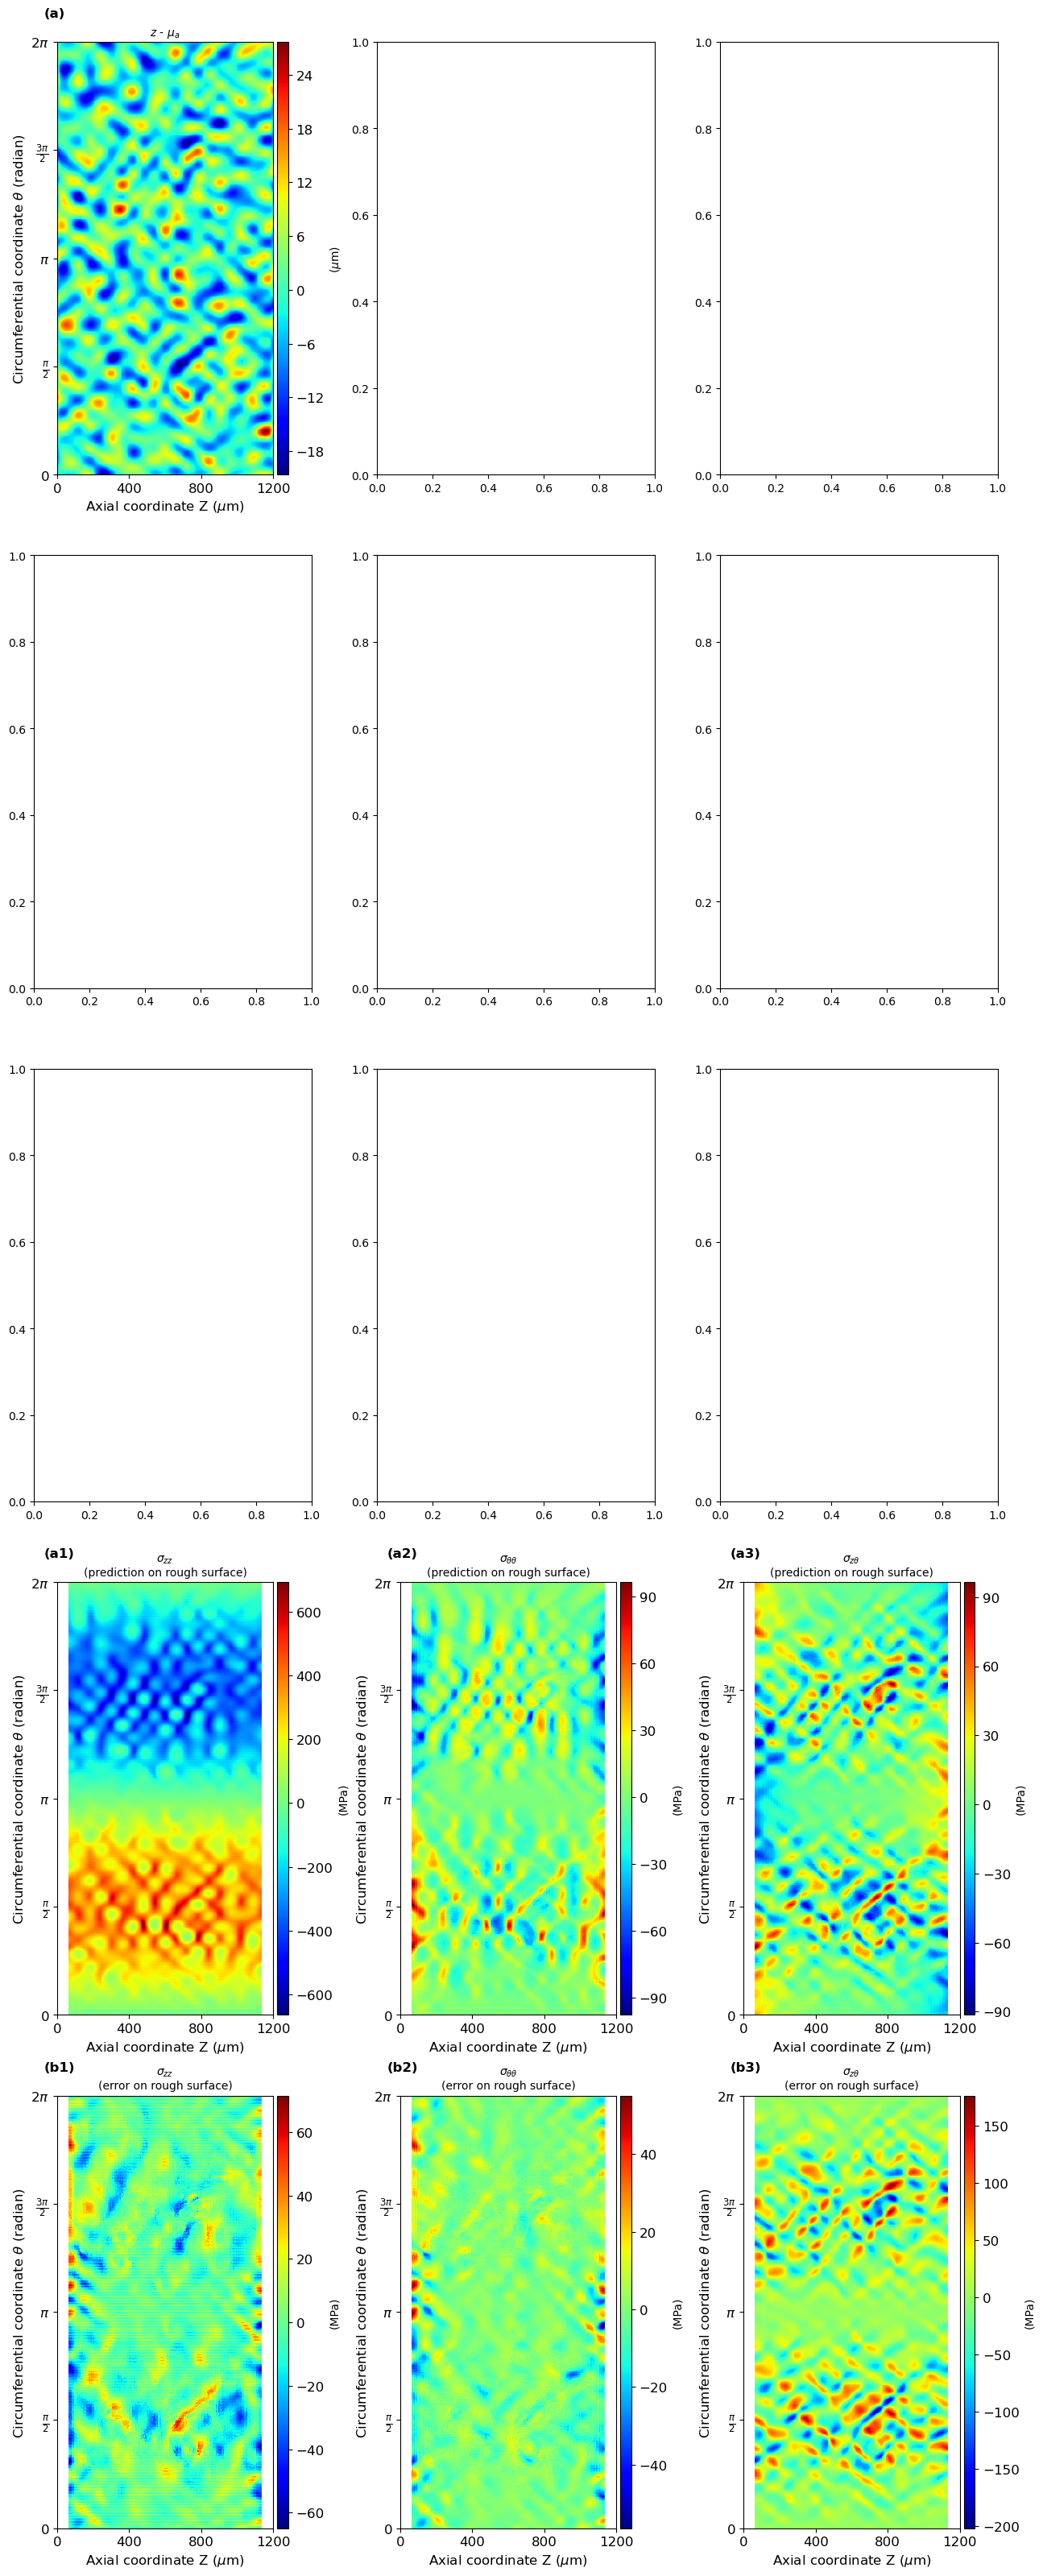

In [16]:

stress_3d_array_flat_simu_masked  = np.where(mask_3d_fem, stress_3d_array_flat_simu,  np.nan)
stress_3d_array_rough_simu_masked = np.where(mask_3d_unet,stress_3d_array_rough_simu, np.nan)
stress_3d_array_rough_unet_masked = np.where(mask_3d_unet,stress_3d_array_rough_unet, np.nan)


del_stress_sim_unet = stress_3d_array_rough_simu_masked - stress_3d_array_rough_unet_masked
print(f"del_stress_sim_unet shape is {del_stress_sim_unet.shape}")

# plt.imshow(times_2d_array, cmap='jet', interpolation='none')
# plt.colorbar()
# plt.title('Roughness profile')
# plt.show()

# Create figures and axes
fig, axes = plt.subplots(5, 3, figsize=(13, 32))  # Adjust figure size if needed

original_length_mm = (num_struct_zeta - 1)*0.004 # mm

# mask_2d_org = cylinder_2d_array < 0.5

# rough_2d_array
# rough_2d_array_masked = np.where(mask_2d_org, rough_2d_array, np.nan)

# draw the roughness 

org_width_mm = 0.004*300
org_height_mm = 0.004*600

crop_pix_col = 0
# rough_2d_array[0:100,0:100] = 500
title = '$\mathit{z}$ - $\mu_{a}$'
label = '($\mu$m)'
half_crop_grids = 0
corner_label = '(a)'
plot_norm_field_cylind(fig, axes, 0, 0, title, label, corner_label, rough_2d_array, crop_pix_col, org_width_mm, org_height_mm, True)

# step names and stress components
steps_name = ['TENSILE_X']
ss_comp = ['11', '22', '33', '12', '13', '23']
row_labels = ['1', '2', '3', '4', '5', '6']

row_plot = 0

for j in range(len(ss_comp)):

    if j == 0 or j == 1 or j == 3:
        idx_stress = j

        # pixels to be cropped off the border of the grid

        crop_pix = 0
        row_plot += 1
        row_label = row_labels[row_plot-1]

        if j == 0:     
            str_sig = "zz"
            str_s = "1"          
        if j == 1:
            str_sig = "\\theta\\theta"
            str_s = '2'    
        if j == 3:
            str_sig = "z\\theta"
            str_s = '6'    
        
        # title = f'$\\sigma_{{{str_sig}}}$ \n(ground truth on rough surface)'
        # # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
        # crop_pix_col = 8
        # corner_label = '(' + 'b' + row_label +')'
        # plot_norm_field_cylind(fig, axes, 1, row_plot-1, title, '(MPa)', corner_label, 
        #                        stress_3d_array_rough_simu_masked[idx_stress,:,:], crop_pix_col,  org_width_mm, org_height_mm,  True)

        # title = f'$\\sigma_{{{str_sig}}}$ \n(ground truth on smooth surface)'
        # # title = '$\sigma_{11}$/s$_{1}$($\mathit{l}$$_{e}$=4$\mu$m)'
        # crop_pix_col = 16
        # corner_label = '(' + 'c' + row_label +')'
        # plot_norm_field_cylind(fig, axes, 2, row_plot-1, title, '(MPa)', corner_label, 
        #                        stress_3d_array_flat_simu_masked[idx_stress,:,:], crop_pix_col,  org_width_mm, org_height_mm,  True)
        
        title = f'$\\sigma_{{{str_sig}}}$ \n(prediction on rough surface)'
        half_crop_grids = 0
        crop_pix_col = 0
        corner_label = '(' + 'a' + row_label +')'
        plot_norm_field_cylind(fig, axes, 3, row_plot-1, title, '(MPa)', corner_label, 
                               stress_3d_array_rough_unet_masked[idx_stress,:,:], crop_pix_col,  org_width_mm, org_height_mm,  True)
        
        title = f'$\\sigma_{{{str_sig}}}$ \n(error on rough surface)'
        half_crop_grids = 0
        crop_pix_col = 0
        corner_label = '(' + 'b' + row_label +')'
        plot_norm_field_cylind(fig, axes, 4, row_plot-1, title, '(MPa)', corner_label, 
                               del_stress_sim_unet[idx_stress,:,:], crop_pix_col,  org_width_mm, org_height_mm,  True)


plt.tight_layout()
plt.show()


In [ ]:

# Plot an example slice (e.g., the first slice along the third dimension)
slice_index = 0  # Choose which slice to plot
plt.imshow(stress_3d_array_rough_unet_masked[slice_index, :, :], cmap='jet', interpolation='none')
plt.colorbar(label='Stress')
plt.title(f'Slice {slice_index} of Masked Stress 3D Array by UNet')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# Plot an example slice (e.g., the first slice along the third dimension)
# slice_index = 0  # Choose which slice to plot
plt.imshow(stress_3d_array_rough_simu_masked[slice_index, :, :], cmap='jet', interpolation='none')
plt.colorbar(label='Stress')
plt.title(f'Slice {slice_index} of Masked Stress 3D Array by FEM')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# Plot an example slice (e.g., the first slice along the third dimension)
# slice_index = 0  # Choose which slice to plot
plt.imshow(stress_3d_array_rough_simu_masked[slice_index, :, :]-stress_3d_array_rough_unet_masked[slice_index, :, :], cmap='jet', interpolation='none')
plt.colorbar(label='Stress')
plt.title(f'Slice {slice_index} of delta Masked Stress 3D Array')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# fig, axes = plt.subplots(4, 3, figsize=(18, 21))
# # draw the roughness 
# crop_pix = 0


# title = '$\mathit{z}$ - $\mu_{a}$'
# label = '($\mu$m)'
# half_crop_grids = 0
# corner_label = '(a)'
# plot_norm_field(fig, axes, 0, 0, title, label, corner_label, stress_3d_array_rough_simu_masked[0], crop_pix, half_crop_grids, original_length_mm, True)


# Graph Neural Network

In [ ]:
import torch
from torch_geometric.data import Data

# Define node features (3 nodes, 2 features each)
x = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0]], dtype=torch.float)

# Define edge connections (edge list)
edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)

# Create a PyTorch-Geometric graph object
graph_data = Data(x=x, edge_index=edge_index)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Generate some example data
data = np.random.rand(10, 10)  # Random data between -5 and 105

# Define the boundaries for the colorbar
boundaries = np.arange(0.1, 0.9, 0.1)
boundaries = np.insert(boundaries, 0, 0)  # Add 0 at the beginning
boundaries = np.append(boundaries, 1)  # Add 1 at the end

# Create a colormap
cmap = plt.get_cmap('jet')

# Create the plot
fig, ax = plt.subplots()
norm = Normalize(vmin=-1, vmax=2, clip=True)
im = ax.imshow(data, cmap=cmap, norm=norm)

# Create the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=boundaries)
cbar.set_label('Value')

# Show the plot
plt.show()

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Example: Define nodes and their features (Defect ID, Size, Shape, Intensity)
nodes = {
    1: {"size": 10.5, "shape": 0.8, "intensity": 150},
    2: {"size": 8.2, "shape": 0.6, "intensity": 170},
    3: {"size": 12.3, "shape": 0.7, "intensity": 140},
    4: {"size": 7.8, "shape": 0.5, "intensity": 160},
}

# Define adjacency list (connections based on defect proximity)
edges = [(1, 2), (2, 3), (3, 4)]

# Create a graph
G = nx.Graph()

# Add nodes with features
for node, features in nodes.items():
    G.add_node(node, **features)

# Add edges
G.add_edges_from(edges)

# Get node colors based on intensity
node_colors = [nodes[n]["intensity"] for n in G.nodes]

# Get node sizes based on defect size
node_sizes = [nodes[n]["size"] * 20 for n in G.nodes]  # Scaled for visibility

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(6, 6))

# Draw the graph on the axes object
pos = nx.spring_layout(G)  # Layout algorithm for positioning
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.coolwarm,
        node_size=node_sizes, edge_color="gray", font_size=10, ax=ax) # Specify ax

# Show the colorbar for intensity
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
plt.colorbar(sm, label="Defect Intensity", ax=ax) # Specify ax

plt.title("Defect Connectivity Graph (CT Image Analysis)")
plt.show()

# # Draw the graph
# plt.figure(figsize=(6, 6))
# pos = nx.spring_layout(G)  # Layout algorithm for positioning
# nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.coolwarm,
#         node_size=node_sizes, edge_color="gray", font_size=10)

# # Show the colorbar for intensity
# sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
# plt.colorbar(sm, label="Defect Intensity")

# plt.title("Defect Connectivity Graph (CT Image Analysis)")
# plt.show()
